# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
cigData = pd.read_csv('CowboyCigsData.csv', usecols=['Time', '#CigSales'], parse_dates=['Time'], index_col='Time')

# NOTE:
This notebook does NOT work as written, and I am working Frank Fletcher's notebook that he shared on the slack to find workarounds.  (https://github.com/frankfletcher/Springboard-Data-Science/blob/master/Module%2021.1%20-%20Cowboys%20and%20Cigrettes%20Case%20Study/Cowboy%20Cigarettes%20Case%20Study%20-%20Tier%203-FrankFletcher-better-version.ipynb)

The originally dataset was altered, and so we need to fix this by subtracting 10e5 and then multiply by 10e3 to make a new dataset where the scale is roughly the same but the variance is in proportion with the scale

In [3]:
# MAKING THIS FIX

cigData = (cigData - 1000000) * 100000

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [4]:
cigData.head()

,#CigSales
Time,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [5]:
print('Column names: ',cigData.columns)
print('Number of columns: ', len(cigData.columns))

Column names:  Index(['#CigSales'], dtype='object')
Number of columns:  1


Let's check out the data types of our columns.

In [6]:
cigData.dtypes

#CigSales    int64
dtype: object

Check whether there are any null values. 

In [7]:
cigData.isna().any()

#CigSales    False
dtype: bool

There are no null values

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [8]:
# did this when I loaded data

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [9]:
# Time is already an index, so changing this code
cigData.index.name = 'Month'

Call a head() to check this has worked. 

In [10]:
cigData.head()

,#CigSales
Month,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


In [11]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   #CigSales  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [12]:
# did this in an earlier step

Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [13]:
y = cigData['#CigSales']

Check the type of our new variable. 

In [14]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [15]:
y.describe()

count    1.440000e+02
mean     2.802986e+07
std      1.199663e+07
min      1.040000e+07
25%      1.800000e+07
50%      2.655000e+07
75%      3.605000e+07
max      6.220000e+07
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

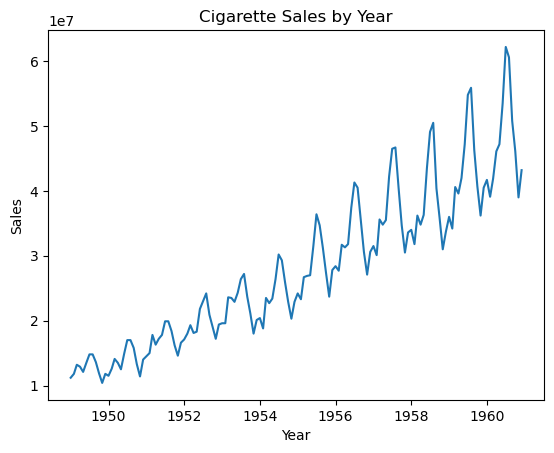

In [16]:
_ = plt.plot(y)
    
_ = plt.ylabel('Sales')
_ = plt.xlabel('Year')
_ = plt.title('Cigarette Sales by Year')

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

<b>MY NOTE:</b> I notice that the sales overall increase overtime, with what looks like annual seasonal trends that get more extreme as time progresses.

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 


### Answer: MULTIPLICATIVE
-------------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

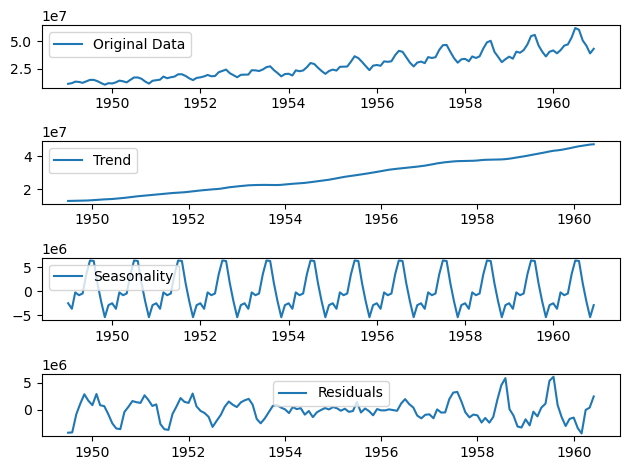

In [17]:
# Import seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose

# Make a variable called decomposition, and assign it y passed to seasonal_decompose() 
decomposition = seasonal_decompose(y)

# Make three variables for trend, seasonal and residual components respectively. 
# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(411)
plt.plot(y, label = 'Original Data')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [18]:
from statsmodels.tsa.stattools import kpss
#NOTE: I originally did: kpss(y) and it printed out the summary statistics, 
#but I like what Frank Fletcher did as it increases readabilty

statistic, p_value, n_lags, critical_values = kpss(cigData, nlags='auto')

print('Statistic: ', statistic)
print('p-value: ', p_value)
print('Number of lags: ', n_lags)
print('Critical values: ', critical_values)

Statistic:  1.6513122354165233
p-value:  0.01
Number of lags:  8
Critical values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\leann\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

In [19]:
# NOTE: I am also including Frank's other way of looking at stationarity,
#as it looks like a useful method.

#This is the 'Augmented Dickey-Fuller Test'

from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}\n')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
     # .to_string() removes the line "dtype: float64"    
    print(out.to_string())         
   #empty line for formatting 
    print() 
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is STATIONARY")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is NOT STATIONARY")


In [20]:
# Do the ADF test on our data:

adf_test(cigData)

Augmented Dickey-Fuller Test: 

ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is NOT STATIONARY


### 3c. Making the data stationary 

### NOTE: 
From here I will be following Frank's method, as the original Springboard notebook made no sense and didn't work. I'll be annotating the process along the way.



Let's recall what our data looks like. 

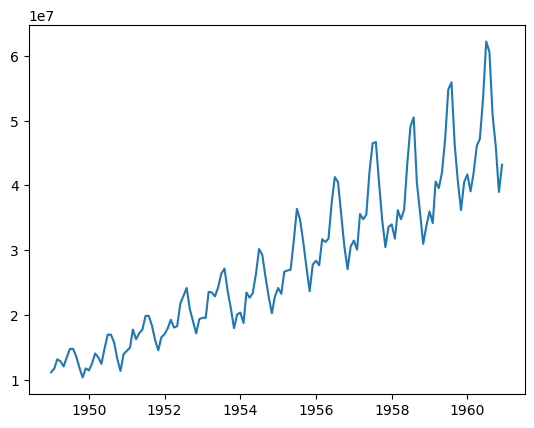

In [21]:
_=plt.plot(y)

In [22]:
# also check out head

cigData.head()

,#CigSales
Month,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


In [23]:
cigData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   #CigSales  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the 
, however, seems constant). 

One ofte used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now.

In [24]:
# previously was taking log of y
dflog = np.log(cigData)


When you plot this, you can see how the variance in our data now remains contant over time.

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import datetime as dt


# utility - polynomial regression
def get_polyregr_pred (df: pd.DataFrame, degree=1, retmodel=False) -> np.ndarray:
    """Return an array of Polynomial regression predictions from a DataFrame
    Alternatively, if retmodel==True, return the entire model
    
    Keyword Arguments:
    df -- A DataFrame with 'Month' and '#CigSales' columns, holding datetime objects and integer prices
    degree -- the degree of the polynomial.  (reminder that degree 1 will return straight linear regressor)
    """
    # @TODO: Assert 'Month' and '#CigSales' columns with datetime and float elements - throw TypeError
    
    # format the data into ndarrays
    df2 = df.reset_index()
    x_arr = df2.Month.map(dt.datetime.toordinal).values.reshape(-1,1)
    y_arr = df2['#CigSales'].values.reshape(-1,1)
    
    # build a polynomial regression pipeline
    polyreg = make_pipeline( PolynomialFeatures(degree),
                             LinearRegression() )
    
    # fit the model to our data
    polyreg.fit(x_arr, y_arr) 
    
    if retmodel == True:
        return polyreg
    
    return polyreg.predict(x_arr)

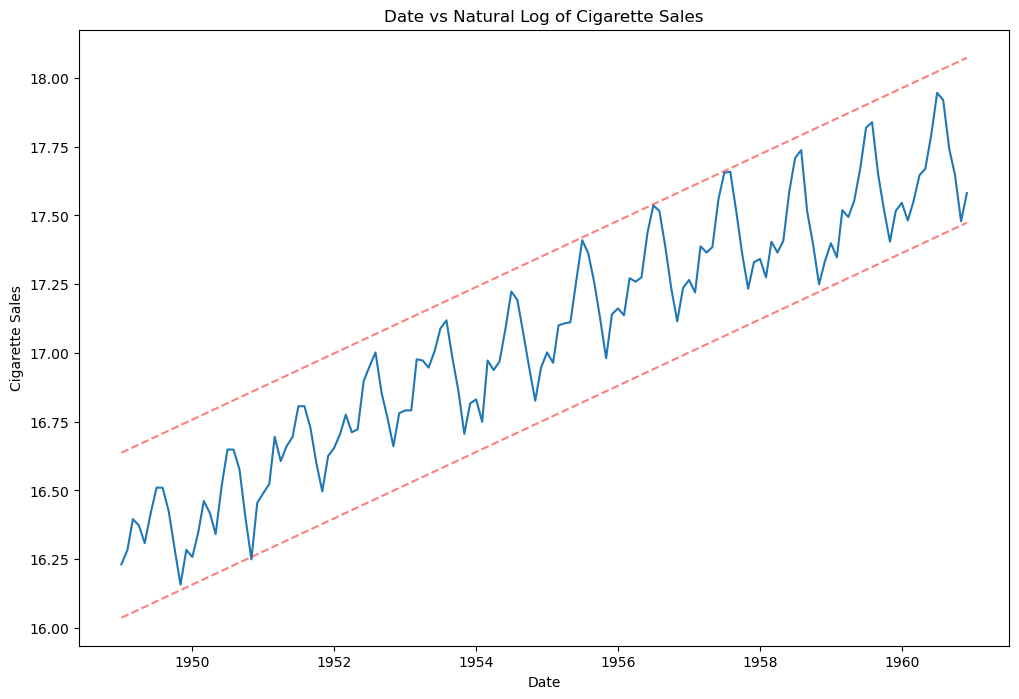

In [26]:
# get a linear regression line to visualize decreased variance in the data
# from year to year
pred = get_polyregr_pred(dflog)

plt.figure(figsize=(12,8))

plt.title('Date vs Natural Log of Cigarette Sales')
plt.plot(dflog)

# use the regression lines to bound the extremities of the data along the y axis
plt.plot(cigData.reset_index().Month, pred+.3, color='red', alpha=.5, ls='--')
plt.plot(cigData.reset_index().Month, pred-.3, color='red', alpha=.5, ls='--')

plt.xlabel('Date')
plt.ylabel('Cigarette Sales');


NOTE: Trying what Frank did, and test the effect of the transformation on the variance by taking the histogram and checking for uniformity or decreased skew.

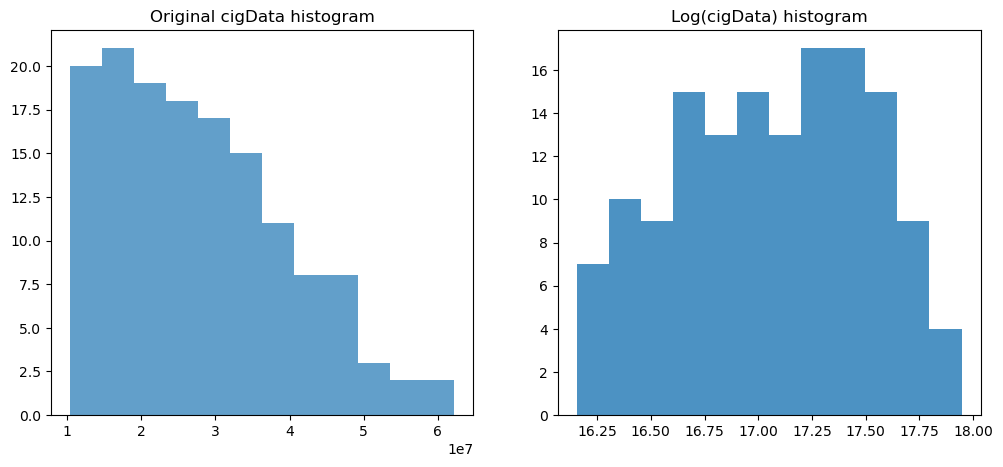

In [27]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.title('Original cigData histogram')
plt.hist(cigData, bins=12, alpha=0.7)

plt.subplot(122)
plt.title('Log(cigData) histogram')
plt.hist(dflog, bins=12, alpha=0.8)

plt.show()

I can confirm that the data has less skew now and is more uniform.

NOTE: The below plot is creating plots of the autocorrelation function (ACF) and the partial autocorrelation function (PACF).

C:\Users\leann\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


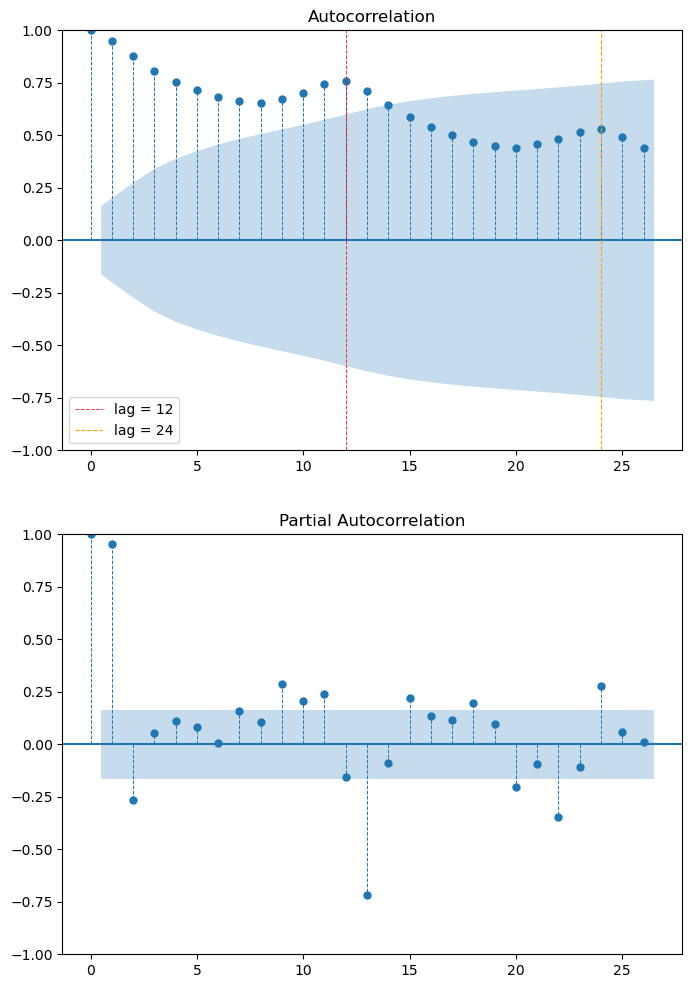

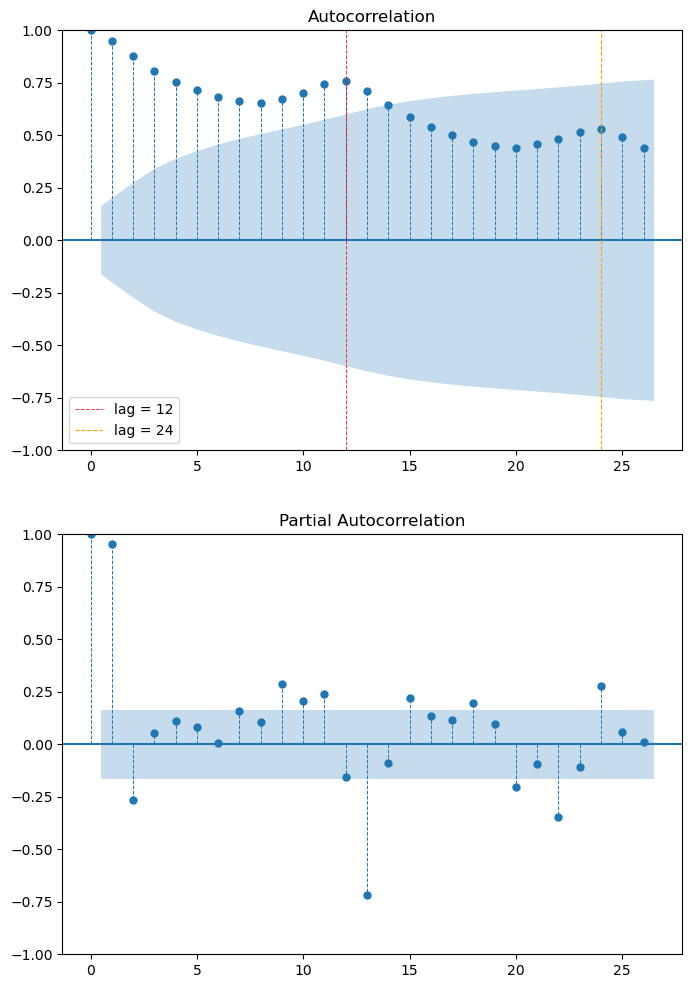

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(8,12))

# plot the ACF
plot_acf(cigData, ax=ax[0], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

# place marker lines on lags 12 and 24 to highligh the period of seasonality
ax[0].axvline(12, color='red', ls='--', alpha=0.8, lw=0.7, label='lag = 12')
ax[0].axvline(24, color='orange', ls='--', alpha=1, lw=0.8, label='lag = 24')
ax[0].legend()

# plot the PACF
plot_pacf(cigData, ax=ax[1], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)


NOTES:
In the autocorrelation plot, I see evidence of seasonal trends and it looks like an autoregressive process. 

In the partical autocorrelation plot, the postive values mean that a higher value at a certain lag time is associated with a higher current value. The negative PACF value around lag 13 suggests that there's a negative correlation between the time series value at time 't' and at time 't-13', after removing the effects of lags 1 through 12. It should be noted that this uniquely negative point comes right after a seasonal bump in the autocorrelation plot, so I am guessing there is a drop in sales right after a seasonal increase.

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [29]:
# again, Frank had a better way of doing this:

# Difference the data with period 12, corresponding to 12 months 
dfdiff = dflog.diff(12)

# remove the first 12 records as they are now filled with NaNs
dfdiff = dfdiff.iloc[12:]

In [30]:
from statsmodels.tsa.stattools import kpss

# use KPSS to test the differenced data and confirm stationarity
# note that because our differencing period aligned with the datas natural
# seasonality, there's a chance that the data is still not stationary
statistic, p_value, n_lags, critical_values = kpss(dfdiff.iloc[1:], nlags='auto')

print('KPSS Test Statistic: '.ljust(22), statistic)
print('p-value: '.ljust(22), p_value)
print('Number of Lags: '.ljust(22), n_lags)
print('Critical Values: '.ljust(22), critical_values)

KPSS Test Statistic:   0.32654190484123513
p-value:               0.1
Number of Lags:        6
Critical Values:       {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\leann\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [31]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


from pandas.plotting import autocorrelation_plot

# NOTE:
Below is where I got hung up and couldn't move past initially, as I could tell something was really off in the original notebook. 

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [32]:
#  MEAN SQUARED ERROR FUNCTION

def get_mse(data, order=(0,0,0), seasonal_order=(0,0,0,0)):
    """
    Creates a 'Seasonal AR Integrated Moving Average w/ eXogenous factors'
    ('SARIMAX') model.
    
    Creates a Train-Test split, fits the data, forecasts the data over the 
    validation period, then compares the forecasted data with the actual data
    """
    
    # Train-Test split. Validation is 24 months in prep to forecast 24 months out
    X = data.iloc[:len(data)-24]
    y = data.drop(X.index)
      
    # define and fit the model
    model = SARIMAX(X, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    
    # predict the future!
    pred = model_fit.forecast(len(y))
    
    # return the MSE on our prediction
    return mean_squared_error(y, pred)

In [33]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Test our get_mse() function
print('MSE: ', get_mse(dflog, (0,1,1)) ) 

MSE:  0.08785507368403543


This MSE is really low, that's great!

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

Again, following Frank's model

In [34]:
# Make a function to evaluate different SARIMAX models with different p, d, and q values.
# As well as different Seasonal p, d, and q values.  It then compares the MSEs
# for all models and returns the model parameters for the lowest Error model.

def get_pdq (data):
    i = 0
    mses = pd.DataFrame()  # holds model parameters and MSEs
    
    # nested loop through all parameters.  this loop could be optimized but
    # is left as-is because it's easier to understand.
    for p in range(0,2):
        for d in range(0,2):
            for q in range (0,3):
                for ps in range(0,2):
                    for ds in range(0,2):
                        for qs in range(0,2):
                            # build/fit/predict model and get the MSE
                            mse = get_mse(data, order=(p,d,q), 
                                          seasonal_order=(ps,ds,qs,12))
                            
                            # save the parameters and MSE
                            mses = mses.append(
                                pd.DataFrame({'p':p, 
                                              'd':d, 
                                              'q':q,
                                              'ps':ps,
                                              'ds':ds,
                                              'qs':qs,
                                              'mse':mse}, index=[i]))
                            i = i+1
             
    # sort our collection by MSE and return the parameters with the lowest MSE
    mses = mses.sort_values(by='mse', axis=0, ascending=True).reset_index()
    return mses.iloc[0]

In [35]:
# Finally, we can find an optimum SARIMAX model for our data.
# Nb. this can take a while...!

# Get the optimal parameters for our model
pdq = get_pdq(dflog)

print('mse: '.ljust(6), pdq.mse)
print()
print('p:'.ljust(6), int(pdq.p))
print('d:'.ljust(6), int(pdq.d))
print('q:'.ljust(6), int(pdq.q))
print('ps:'.ljust(6), int(pdq.ps))
print('ds:'.ljust(6), int(pdq.ds))
print('qs:'.ljust(6), int(pdq.qs))
print('s:'.ljust(6), 12)

mse:   0.0014493344260093448

p:     0
d:     0
q:     1
ps:    1
ds:    1
qs:    1
s:     12


try (p,d,q) =(0,0,1)

The notebook said: So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model. 

BUT I did not get that, I am using 0,0,1 as I found above. However, this is different than what Frank found (1,1,2), but I will try mine out. 

In [36]:
# define and fit the model
model = SARIMAX(dflog, order=(pdq.p, pdq.d, pdq.q), 
                seasonal_order=(pdq.ps, pdq.ds, pdq.qs, 12), freq='MS')
model_fit = model.fit()

# predict the future!
forecast = model_fit.forecast(24)
pred = model_fit.predict()[12:]  # give it 1 period to create predictions

model_fit.mse

22.27908962468825

We can take a look at a summary of the model this library has built around our data.

In [37]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          #CigSales   No. Observations:                  144
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 12)   Log Likelihood                 181.100
Date:                            Thu, 06 Jul 2023   AIC                           -354.200
Time:                                    12:33:31   BIC                           -342.669
Sample:                                01-01-1949   HQIC                          -349.515
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5024      0.076      6.642      0.000       0.354       0.651
ar.S.L12       0.9996      0.013     79.723      0.000       0.975       1.024
ma.S.L12      -0.9579      0.609     -1.574      0.116      -2.151       0.235
sigma2         0.0029      0.002      1.764      0.078      -0.000       0.006
===================================================================================
Ljung-Box (L1) (Q):                  10.66   Jarque-Bera (JB):                 5.07
Prob(Q):                              0.00   Prob(JB):                         0.08
Heteroskedasticity (H):               0.44   Skew:                             0.33
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

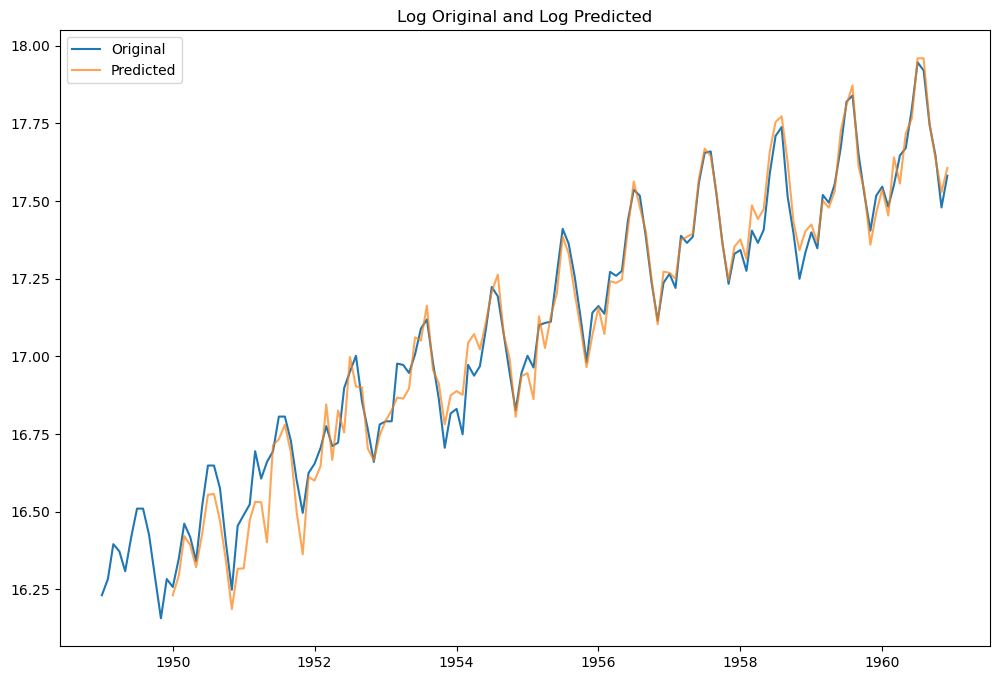

In [38]:
# Overlay our prediction over the actual data to get a sense of how good 
# the model is.

plt.figure(figsize=(12,8))

plt.title('Log Original and Log Predicted')
plt.plot(dflog, label='Original')
plt.plot(pred, alpha=0.7, label='Predicted')

plt.legend();

This is pretty great!

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

In [40]:
# again will follow Frank's method as I trust him more on this. 

# define and fit the model
model = SARIMAX(dflog, order=(2,0,0), seasonal_order=(0, 1, 1, 12), freq='MS')
model_fit_aa = model.fit()

# predict the future!
forecast_aa = model_fit_aa.forecast(24)
pred_aa = model_fit_aa.predict()[12:] # # give it 1 period to create predictions

model_fit_aa.mse

22.27664026690219

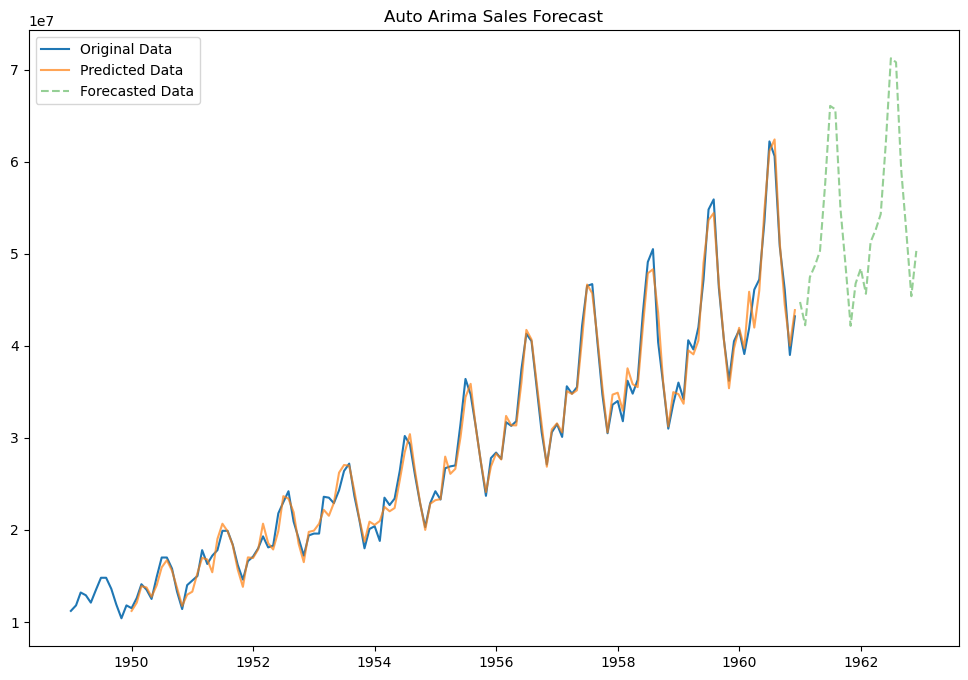

In [41]:
# use auto arima.

plt.figure(figsize=(12,8))

# plot our original data, with prediction overlay and then project the forecast
plt.title('Auto Arima Sales Forecast')
plt.plot(np.exp(dflog), label='Original Data')
plt.plot(np.exp(pred_aa), alpha=0.7, label='Predicted Data')
plt.plot(np.exp(forecast_aa), label='Forecasted Data', alpha=0.5, ls='--')

plt.legend();


## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 